In [1]:
import sys
import anndata
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import numpy as np
sys.path.insert(-1, '../..')
import _utils

In [2]:
adata = anndata.read('../lung_annotation/annotation/query_and_reference_final.h5ad')

In [3]:
adata

AnnData object with n_obs × n_vars = 105322 × 4000
    obs: 'tissue_in_publication', 'donor_id', 'free_annotation', 'compartment', 'cell_type_ontology_term_id', 'cell_type', 'assay', 'sex', 'tissue', 'cell_ontology_class', 'cell_ontology_class_tissue', 'donor_tissue', 'assay_correct', 'donor_assay', '_batch_annotation', '_labels_annotation', '_ref_subsample', 'paper_annotation', 'sample', '_dataset', 'n_counts', 'popv_celltypist_prediction', 'popv_celltypist_prediction_probabilities', 'popv_knn_on_bbknn_prediction', 'popv_knn_on_bbknn_prediction_probabilities', 'popv_knn_on_scanorama_prediction', 'popv_knn_on_scanorama_prediction_probabilities', 'subsampled_labels', '_scvi_batch', '_scvi_labels', 'popv_knn_on_scvi_prediction', 'popv_knn_on_scvi_prediction_probabilities', '_labels_annotation_cell_ontology_id', 'popv_onclass_prediction', 'popv_onclass_seen', 'popv_onclass_prediction_probabilities', 'popv_onclass_seen_probabilities', 'popv_rf_prediction', 'popv_rf_prediction_probabilities

In [4]:
adata.obs['popv_prediction_score'].value_counts()

8    39814
7    35496
6    15293
5     8176
4     4892
3     1540
2      108
1        3
Name: popv_prediction_score, dtype: int64

In [5]:
adata

AnnData object with n_obs × n_vars = 105322 × 4000
    obs: 'tissue_in_publication', 'donor_id', 'free_annotation', 'compartment', 'cell_type_ontology_term_id', 'cell_type', 'assay', 'sex', 'tissue', 'cell_ontology_class', 'cell_ontology_class_tissue', 'donor_tissue', 'assay_correct', 'donor_assay', '_batch_annotation', '_labels_annotation', '_ref_subsample', 'paper_annotation', 'sample', '_dataset', 'n_counts', 'popv_celltypist_prediction', 'popv_celltypist_prediction_probabilities', 'popv_knn_on_bbknn_prediction', 'popv_knn_on_bbknn_prediction_probabilities', 'popv_knn_on_scanorama_prediction', 'popv_knn_on_scanorama_prediction_probabilities', 'subsampled_labels', '_scvi_batch', '_scvi_labels', 'popv_knn_on_scvi_prediction', 'popv_knn_on_scvi_prediction_probabilities', '_labels_annotation_cell_ontology_id', 'popv_onclass_prediction', 'popv_onclass_seen', 'popv_onclass_prediction_probabilities', 'popv_onclass_seen_probabilities', 'popv_rf_prediction', 'popv_rf_prediction_probabilities

In [6]:
low_agreement_scores = ['1', '2', '3', '4', '5']
high_agreement_scores = ['6', '7', '8']

replace_dict = dict.fromkeys(low_agreement_scores, 'Low Consensus')
replace_dict.update(dict.fromkeys(high_agreement_scores, 'High Consensus'))

adata.obs['popv_score_agreement'] = adata.obs['popv_prediction_score'].astype(str).replace(replace_dict)
adata.obs['popv_score_agreement'] = adata.obs['popv_score_agreement'].astype('category').cat.reorder_categories(['Low Consensus','High Consensus'])

In [7]:
adata.obs['popv_score_agreement'].value_counts()

High Consensus    90603
Low Consensus     14719
Name: popv_score_agreement, dtype: int64

In [8]:
adata.obsm['X_umap'] = adata.obsm['X_scanvi_umap_popv']

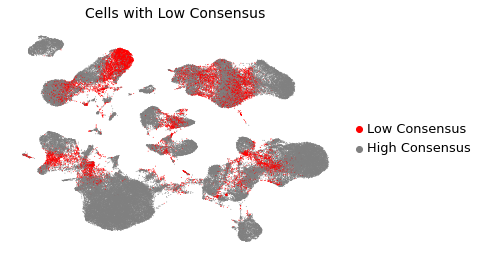

In [9]:
ax = sc.pl.umap(adata, 
                color = 'popv_score_agreement',
                palette = {
                      'Low Consensus':'red',
                      'High Consensus':'gray',
                     },
                title='Cells with Low Consensus',
                return_fig=True,
                size=3
          )

ax.get_figure().savefig('fig2/high_uncertainty.pdf', bbox_inches='tight', dpi=600)



# Tcells

In [10]:
tcells_cells = ['CD4-positive, alpha-beta T cell', 'CD8-positive, alpha-beta T cell', 'effector CD4-positive, alpha-beta T cell', 'effector CD8-positive, alpha-beta T cell', 'mature NK T cell']
tcells = adata[adata.obs['cell_ontology_class'].isin(tcells_cells)].copy()

/home/cane/miniconda3/lib/python3.8/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


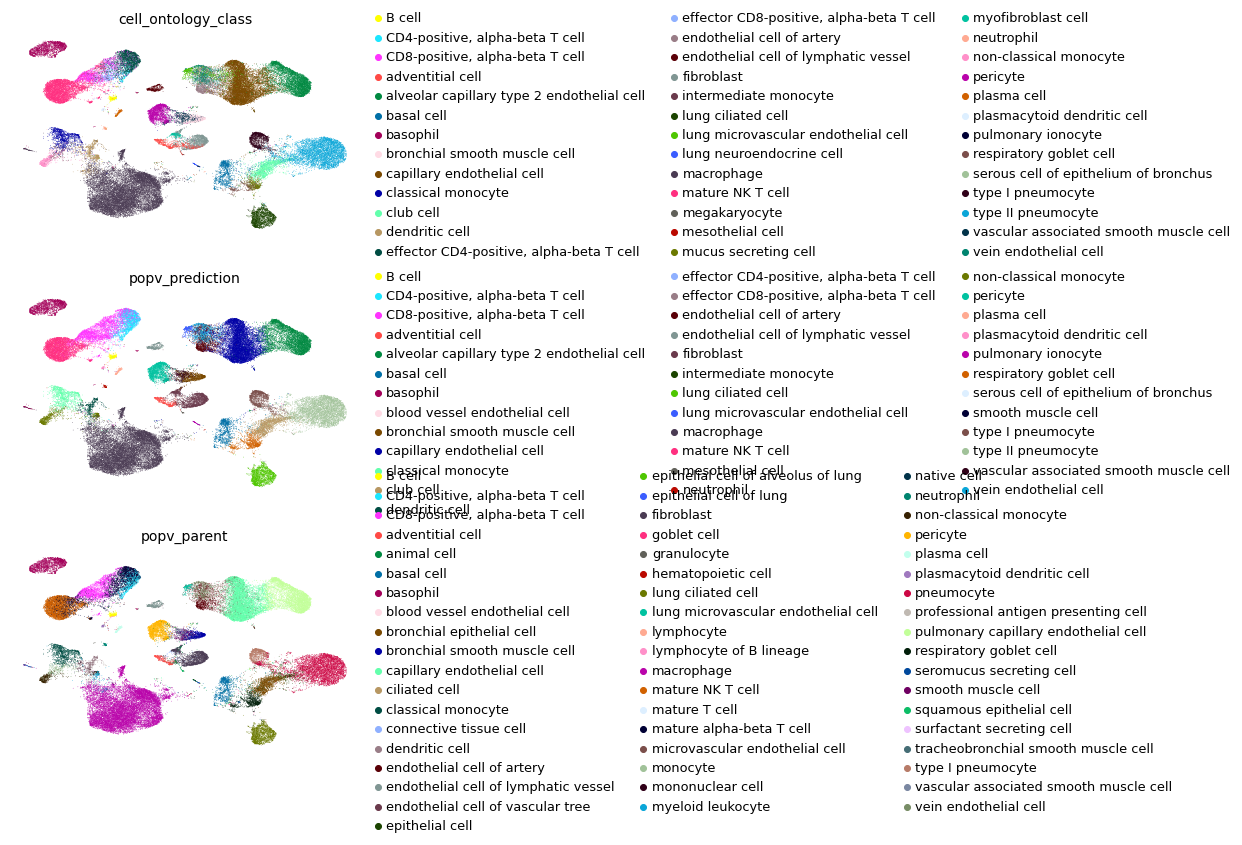

In [11]:
fig = sc.pl.umap(
    adata[adata.obs['_dataset']=='query'],
    color= ['cell_ontology_class', 'popv_prediction', 'popv_parent'],
    ncols=1)

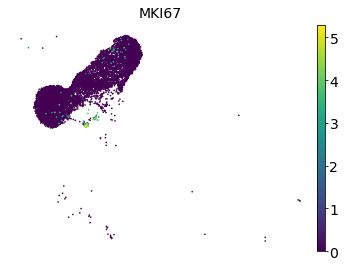

In [168]:
sc.pl.umap(query, color=['MKI67'], ncols=2, frameon=False, legend_fontsize='small',
           show=True)

In [14]:
from scanpy.plotting import palettes

/home/cane/miniconda3/lib/python3.8/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


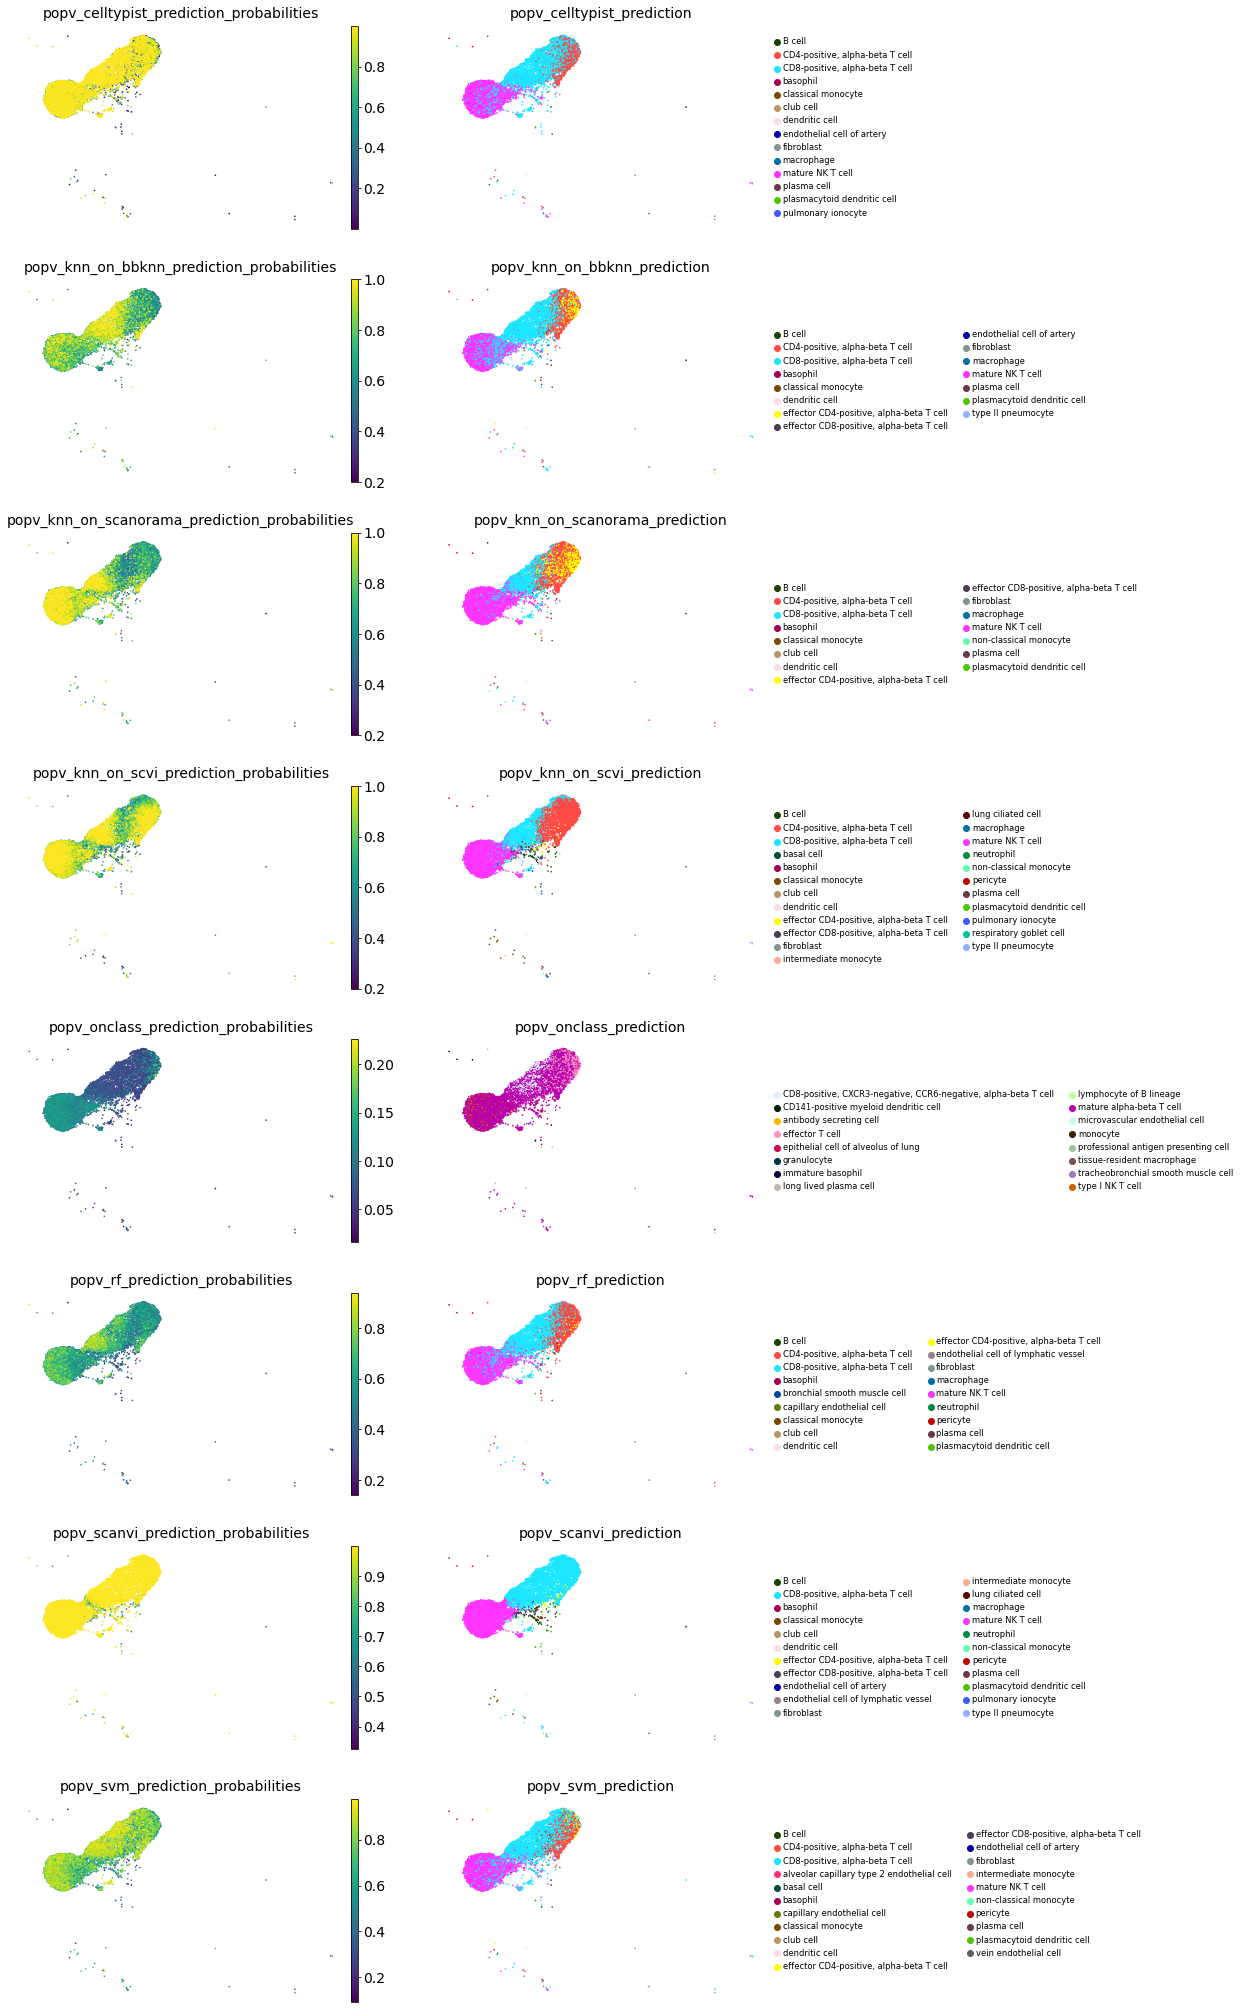

In [18]:
cell_types = pd.unique(tcells.obs[[i for i in (list(tcells.uns['prediction_keys']) + ['popv_parent'] )]].values.ravel('K'))
palette = palettes.default_102
query = tcells[tcells.obs['_dataset']=='query']
sub_cluster_id_colors = {i: j for i, j in zip(list(cell_types), palette)}
color_keys = [[i+'_probabilities', i] for i in query.uns['prediction_keys']]
color_keys =  sum(color_keys, [])
sc.pl.umap(query, color=color_keys, ncols=2, palette=sub_cluster_id_colors, frameon=False, legend_fontsize='small',
           show=True, save='predictors_tcell.pdf')

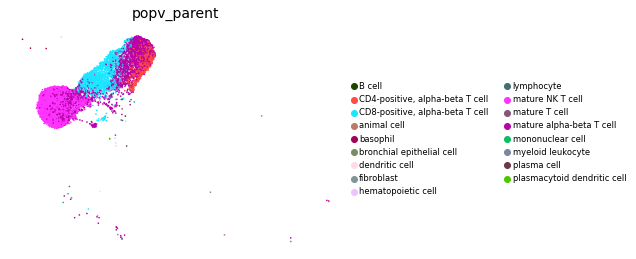

In [19]:
sc.pl.umap(query, color='popv_parent', ncols=2, palette=sub_cluster_id_colors, frameon=False, legend_fontsize='small',
           show=True)

In [11]:
ct_paper = np.unique(tcells[tcells.obs['_dataset']=='query'].obs['paper_annotation'])
for i in ct_paper:
    tcells.obs[i] = [i if j==i else None for j in tcells.obs['paper_annotation']]
fig = sc.pl.umap(tcells[tcells.obs['_dataset']=='query'], color = ct_paper, ncols=3, legend_loc='on data', na_in_legend=False, return_fig=True)
fig.savefig('fig2/fig2_umap_query_tcell.pdf', bbox_inches='tight')

NameError: name 'np' is not defined

/home/cane/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


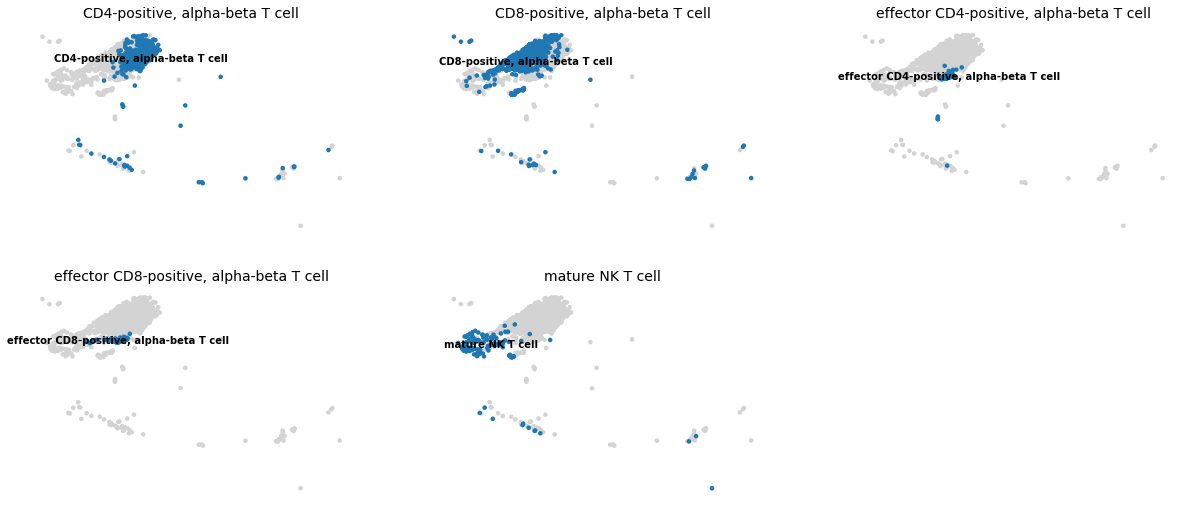

In [ ]:
ct_paper = np.unique(tcells[tcells.obs['_dataset']=='ref'].obs['cell_ontology_class'])
for i in ct_paper:
    tcells.obs[i] = [i if j==i else None for j in tcells.obs['cell_ontology_class']]
fig = sc.pl.umap(tcells[tcells.obs['_dataset']=='ref'], color = ct_paper, ncols=3, legend_loc='on data', na_in_legend=False, return_fig=True)
fig.savefig('fig2/fig2_umap_ref_tcell.pdf', bbox_inches='tight')

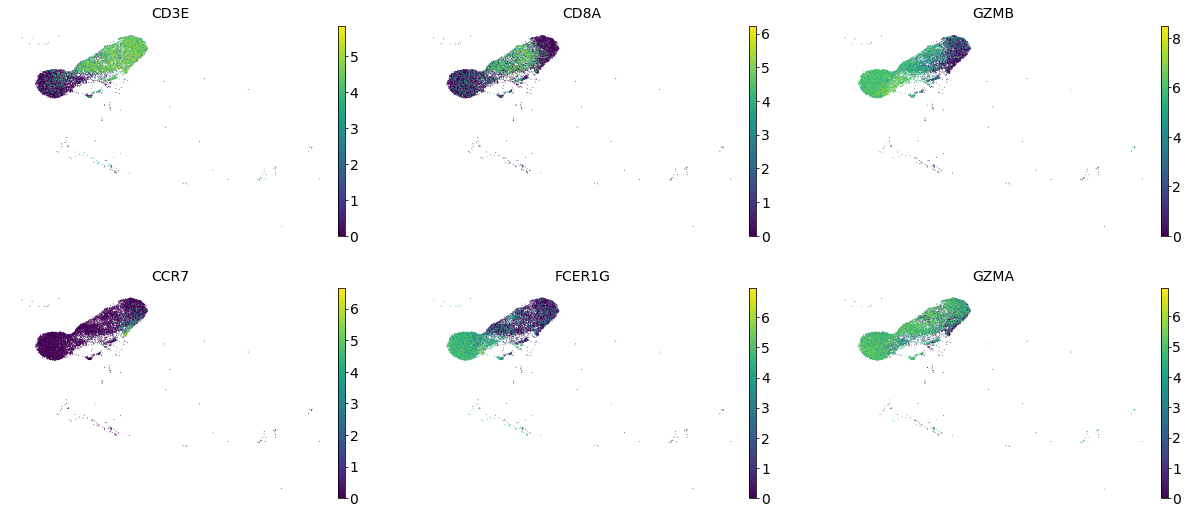

In [ ]:
fig = sc.pl.umap(tcells, color=['CD3E', 'CD8A', 'GZMB', 'CCR7', 'FCER1G', 'GZMA'], ncols=3, size=3, return_fig=True)
fig.savefig('fig2/fig2_umap_markers.pdf', bbox_inches='tight')

/home/cane/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


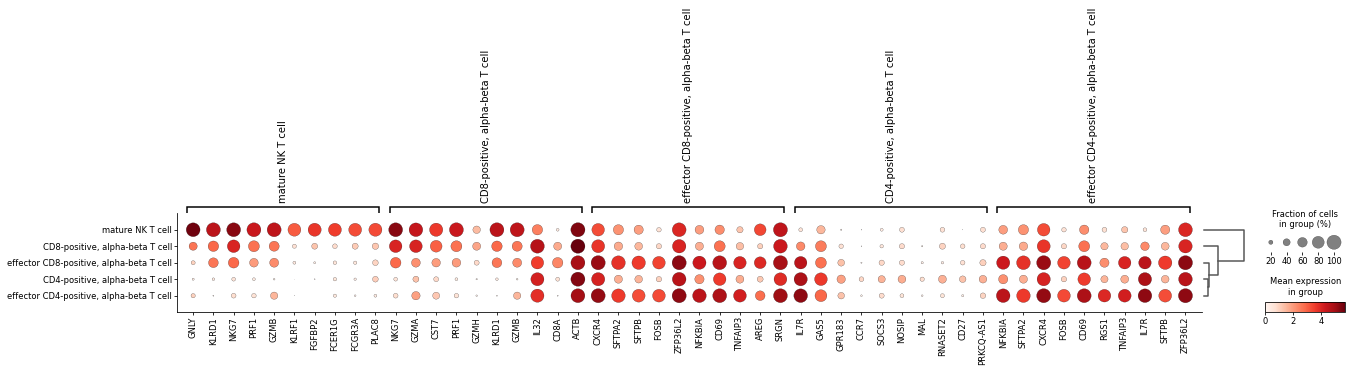

In [ ]:
ref = tcells[tcells.obs['_dataset']=='ref']
ref.uns['log1p']['base'] = 2
sc.tl.rank_genes_groups(ref, groupby='cell_ontology_class')
fig = sc.pl.rank_genes_groups_dotplot(ref, return_fig=True)
fig.savefig('fig2/fig2_ts_de_tcell.pdf', bbox_inches='tight')

/home/cane/miniconda3/lib/python3.8/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


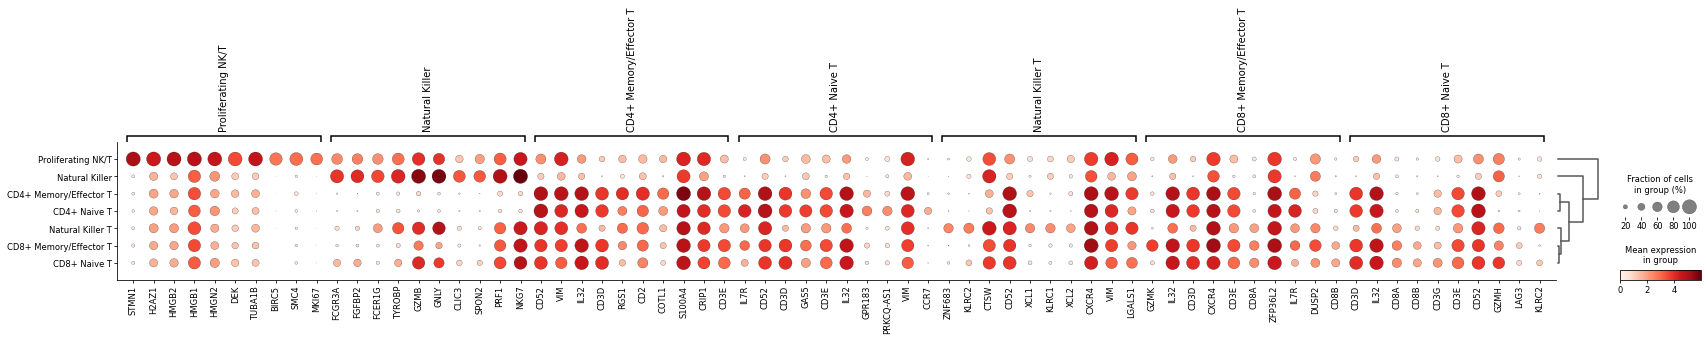

In [12]:
query = tcells[tcells.obs['_dataset']=='query']
query.uns['log1p']['base'] = 2
sc.tl.rank_genes_groups(query, groupby='paper_annotation')
fig = sc.pl.rank_genes_groups_dotplot(query, return_fig=True)
fig.savefig('fig2/fig2_lca_de_tcell.pdf', bbox_inches='tight')

/home/cane/miniconda3/lib/python3.8/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


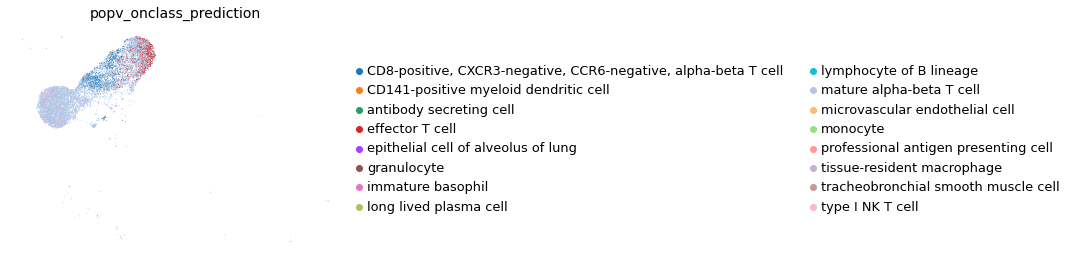

In [14]:
fig = sc.pl.umap(tcells[tcells.obs['_dataset']=='query'], color = ['popv_onclass_prediction'], ncols=3, size=3, return_fig=True)
fig.savefig('fig2/fig2_umap_onclass.pdf', bbox_inches='tight')


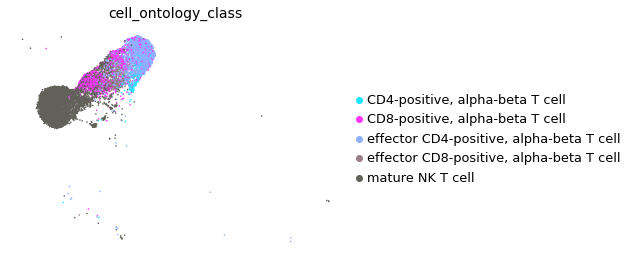

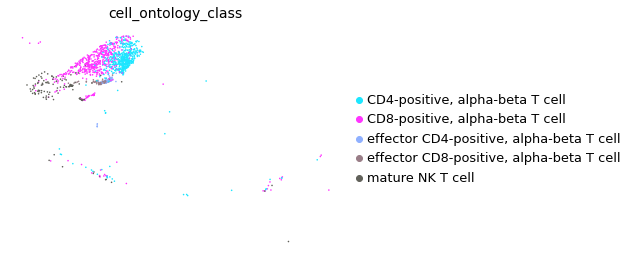

In [57]:
sc.pl.umap(tcells[tcells.obs['_dataset']=='query'], color = ['cell_ontology_class'], ncols=1, size=10)
sc.pl.umap(tcells[tcells.obs['_dataset']=='ref'], color = ['cell_ontology_class'], ncols=1, size=10)

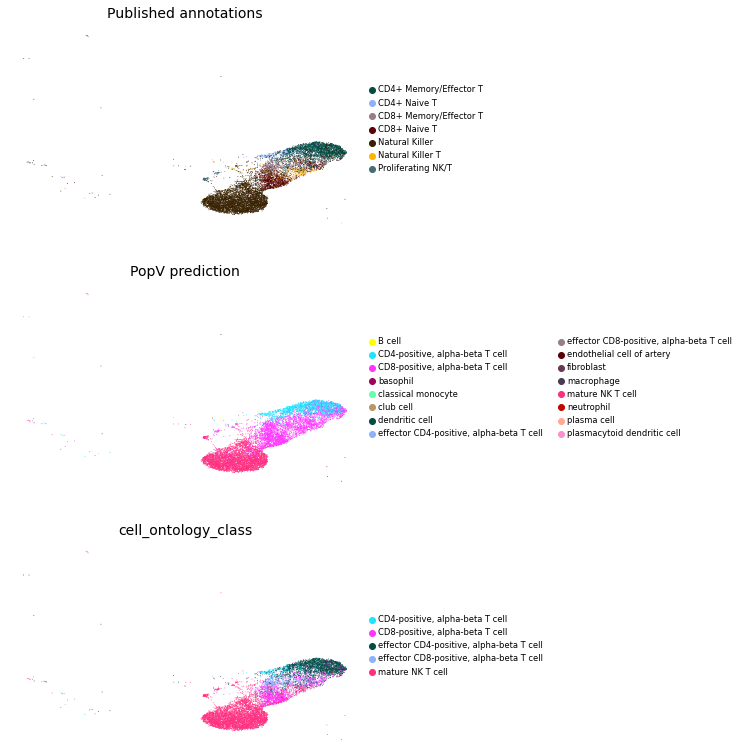

In [37]:
ax = sc.pl.umap(tcells, color=['paper_annotation', 'popv_prediction', 'cell_ontology_class'], ncols=1, legend_fontsize='small', dimensions=[1, 0],
           title=['Published annotations', 'PopV prediction'],
           return_fig=True,
           size=3
          )

ax.get_figure().savefig('fig2/tcells.pdf', bbox_inches='tight', dpi=600)

# Endothelial cells

In [20]:
endothelial_cells = [
    'Capillary',
    'Capillary Aerocyte',
    'Bronchial Vessel 2',
    'Vein',
    'Artery',
    'Bronchial Vessel 1',
    'Lymphatic',
    'Capillary Intermediate 2',
    'Capillary Intermediate 1'
]

In [21]:
endothelial = adata[adata.obs['paper_annotation'].isin(endothelial_cells)].copy()
endothelial = endothelial[
    endothelial.obs['popv_prediction'].isin(endothelial.obs['popv_prediction'].value_counts().index[endothelial.obs['popv_prediction'].value_counts() > 10])
]

/home/cane/miniconda3/lib/python3.8/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


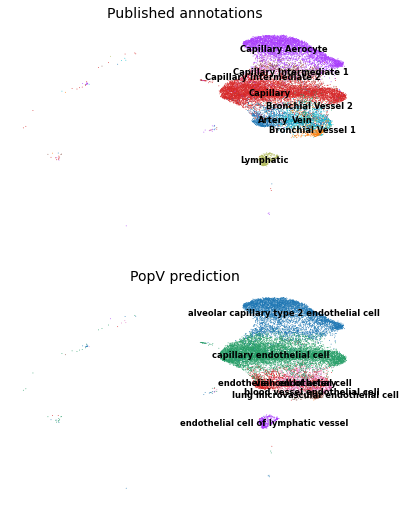

In [22]:
ax = sc.pl.umap(endothelial, color=['paper_annotation', 'popv_prediction'], ncols=1, legend_loc='on data', legend_fontsize='small', dimensions=[1, 0],
           title=['Published annotations', 'PopV prediction'],
           return_fig=True,
           size=3
          )

ax.get_figure().savefig('fig2/endothelial_cells.pdf', bbox_inches='tight', dpi=600)

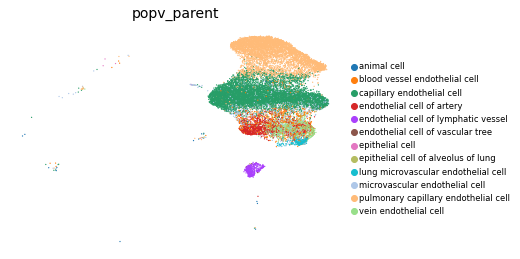

In [24]:
ax = sc.pl.umap(endothelial, color=['popv_parent'], ncols=1, legend_fontsize='small', dimensions=[1, 0])

In [25]:
endothelial.obs[['popv_parent', 'paper_annotation']].value_counts()

popv_parent                           paper_annotation        
capillary endothelial cell            Capillary                   7432
pulmonary capillary endothelial cell  Capillary Aerocyte          4848
endothelial cell of artery            Artery                      1089
vein endothelial cell                 Vein                         911
microvascular endothelial cell        Capillary                    607
endothelial cell of lymphatic vessel  Lymphatic                    497
blood vessel endothelial cell         Artery                       372
pulmonary capillary endothelial cell  Capillary Intermediate 1     369
capillary endothelial cell            Capillary Intermediate 1     300
                                      Capillary Intermediate 2     290
blood vessel endothelial cell         Vein                         251
lung microvascular endothelial cell   Bronchial Vessel 1           208
blood vessel endothelial cell         Capillary                    145
              

In [42]:
sc.pp.neighbors(endothelial, use_rep="X_scanvi", n_neighbors=10)
sc.tl.umap(endothelial, min_dist=0.5)


In [43]:
endothelial.uns['paper_annotation_colors']

['#1f77b4',
 '#ff7f0e',
 '#279e68',
 '#d62728',
 '#aa40fc',
 '#8c564b',
 '#e377c2',
 '#b5bd61',
 '#17becf']

In [44]:
endothelial.obs['popv_prediction'].value_counts()

capillary endothelial cell                    9135
alveolar capillary type 2 endothelial cell    5670
endothelial cell of artery                    1578
vein endothelial cell                         1218
endothelial cell of lymphatic vessel           506
lung microvascular endothelial cell            339
blood vessel endothelial cell                   19
Name: popv_prediction, dtype: int64

In [45]:
palette = {i: k for k, i in palette.items()}

AttributeError: 'list' object has no attribute 'items'

In [ ]:
palette

{'alveolar capillary type 2 endothelial cell': '#1f77b4',
 'capillary endothelial cell': '#ff7f0e',
 'endothelial cell of lymphatic vessel': '#279e68',
 'endothelial cell of artery': '#d62728',
 'vein endothelial cell': '#aa40fc',
 'lung microvascular endothelial cell': '#8c564b',
 'Capillary Intermediate 1': '#e377c2',
 'Capillary Intermediate 2': '#b5bd61',
 'blood vessel endothelial cell': '#17becf'}

In [ ]:
palette = {
    'Capillary Aerocyte': '#1f77b4',
    'Capillary': '#ff7f0e',
    'Lymphatic': '#279e68',
    'Artery': '#d62728',
    'Vein': '#aa40fc',
    'Bronchial Vessel 1': '#8c564b',
    'Capillary Intermediate 1': '#e377c2',
    'Capillary Intermediate 2': '#b5bd61',
    'Bronchial Vessel 2': '#17becf',
    'alveolar capillary type 2 endothelial cell': '#1f77b4',
    'capillary endothelial cell': '#ff7f0e',
    'endothelial cell of lymphatic vessel': '#279e68',
    'endothelial cell of artery': '#d62728',
    'vein endothelial cell': '#aa40fc',
    'lung microvascular endothelial cell': '#8c564b',
    'blood vessel endothelial cell': '#17becf'
}

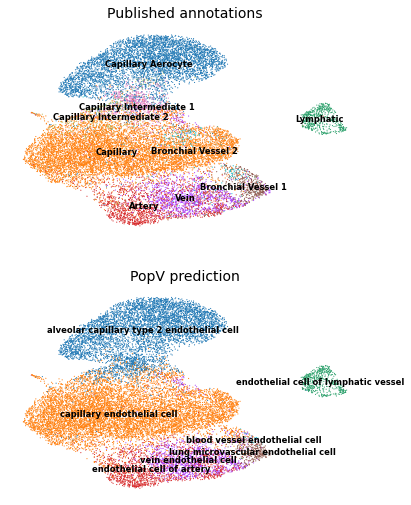

In [ ]:
ax = sc.pl.umap(endothelial, color=['paper_annotation', 'popv_prediction'], ncols=1, legend_loc='on data', legend_fontsize='small', dimensions=[0, 1],
           title=['Published annotations', 'PopV prediction', ''],
           return_fig=True,
           size=5,
           palette=palette
          )

ax.get_figure().savefig('fig2/endothelial_cells_recomputed.pdf', bbox_inches='tight', dpi=600)

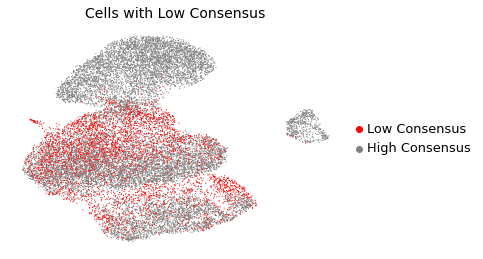

In [ ]:
ax = sc.pl.umap(endothelial, 
                color = 'popv_score_agreement',
                palette = {
                      'Low Consensus':'red',
                      'High Consensus':'gray',
                     },
                title='Cells with Low Consensus',
                return_fig=True,
                size=5
          )

ax.get_figure().savefig('fig2/endothelial_high_uncertainty.pdf', bbox_inches='tight', dpi=600)



In [46]:
query.obs['paper_annotation']

P1_3_CTAAGACAGTGCGATG                Capillary
P1_3_GCGCCAACAGTAACGG       Capillary Aerocyte
P1_3_GCGAGAAGTAAGGGAA       Capillary Aerocyte
P1_3_GCGAGAACACAGAGGT       Capillary Aerocyte
P1_3_GCGAGAACAAATACAG       Capillary Aerocyte
                                   ...        
N14_B002460.gencode.vH29             Capillary
L2_B002460.gencode.vH29              Capillary
H9_B002460.gencode.vH29                 Artery
H4_B003269.gencode.vH29              Capillary
H12_B003269.gencode.vH29             Capillary
Name: paper_annotation, Length: 18465, dtype: category
Categories (9, object): ['Artery', 'Bronchial Vessel 1', 'Bronchial Vessel 2', 'Capillary', ..., 'Capillary Intermediate 1', 'Capillary Intermediate 2', 'Lymphatic', 'Vein']

# Further interrogation

In [171]:
endothelial_cells_ts = [
    'capillary endothelial cell',
    'alveolar capillary type 2 endothelial cell',
    'endothelial cell of artery',
    'vein endothelial cell',
    'endothelial cell of lymphatic vessel',
    'lung microvascular endothelial cell',
    'blood vessel endothelial cell'
]

In [173]:
endothelial_all = adata[np.logical_or(adata.obs['paper_annotation'].isin(endothelial_cells), adata.obs['cell_ontology_class'].isin(endothelial_cells_ts))].copy()
endothelial_all = endothelial_all[
    endothelial_all.obs['popv_prediction'].isin(endothelial_all.obs['popv_prediction'].value_counts().index[endothelial_all.obs['popv_prediction'].value_counts() > 10])
]

In [174]:
endothelial_all.obs['_dataset'].value_counts()

query    18474
ref       2775
Name: _dataset, dtype: int64

/home/cane/miniconda3/lib/python3.8/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


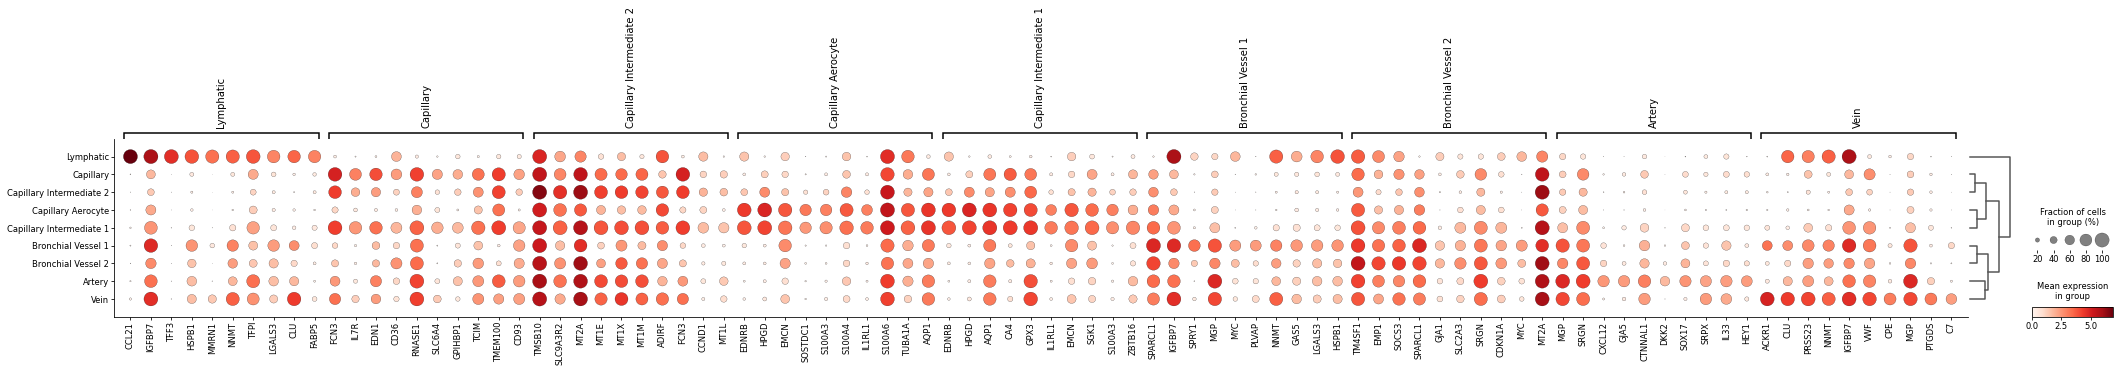

In [175]:
query = endothelial_all[endothelial_all.obs['_dataset']=='query']
query.uns['log1p']['base'] = 2
sc.tl.rank_genes_groups(query, groupby='paper_annotation')
fig = sc.pl.rank_genes_groups_dotplot(query, return_fig=True, min_logfoldchange=1.)
fig.savefig('fig2/fig2_lca_de_endothelial.pdf', bbox_inches='tight')

In [177]:
from scanpy.plotting import palettes

In [178]:
sc.pp.neighbors(endothelial_all, use_rep="X_scanvi", n_neighbors=10)
sc.tl.umap(endothelial_all, min_dist=0.5)

In [179]:
query = endothelial_all[endothelial_all.obs['_dataset']=='query']
ref = endothelial_all[endothelial_all.obs['_dataset']=='ref']

In [180]:
endothelial_all.obs['_dataset'].value_counts()

query    18474
ref       2775
Name: _dataset, dtype: int64

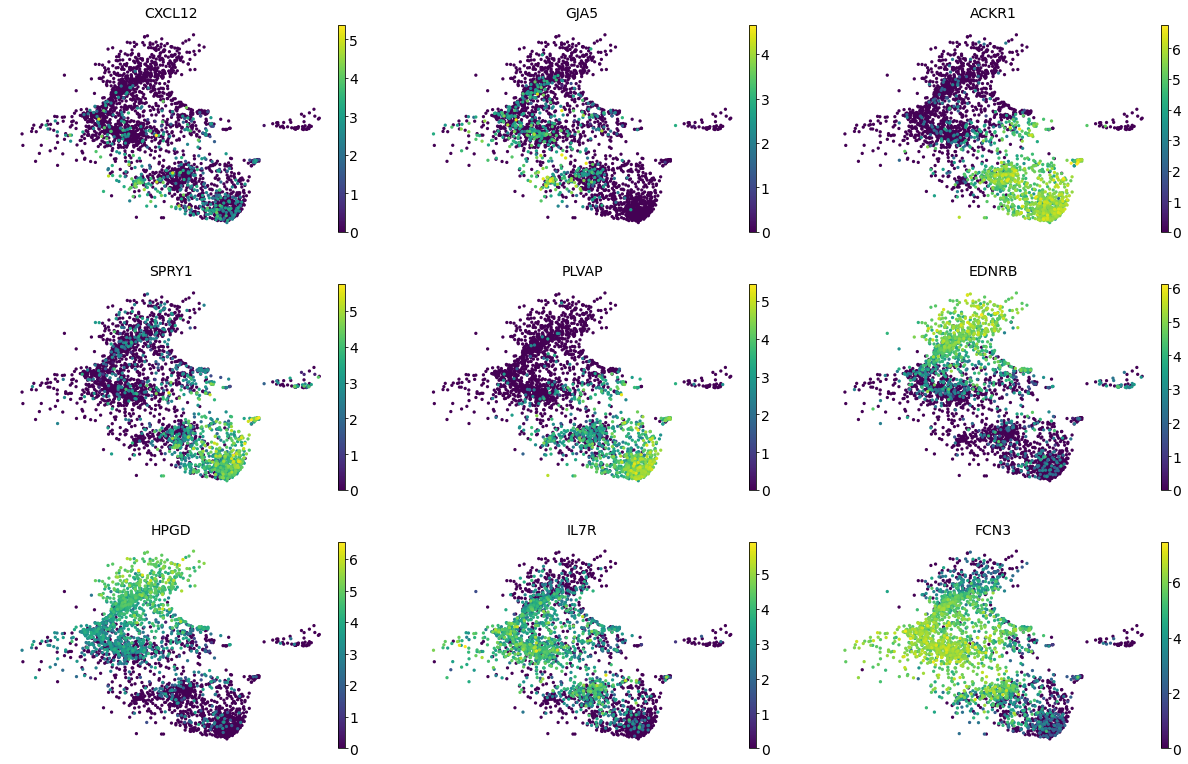

In [181]:
sc.pl.umap(ref, color=['CXCL12', 'GJA5', 'ACKR1', 'SPRY1', 'PLVAP', 'EDNRB', 'HPGD', 'IL7R', 'FCN3'], ncols=3, frameon=False, legend_fontsize='small',
           show=True, save='markers_endothelial_query.pdf')

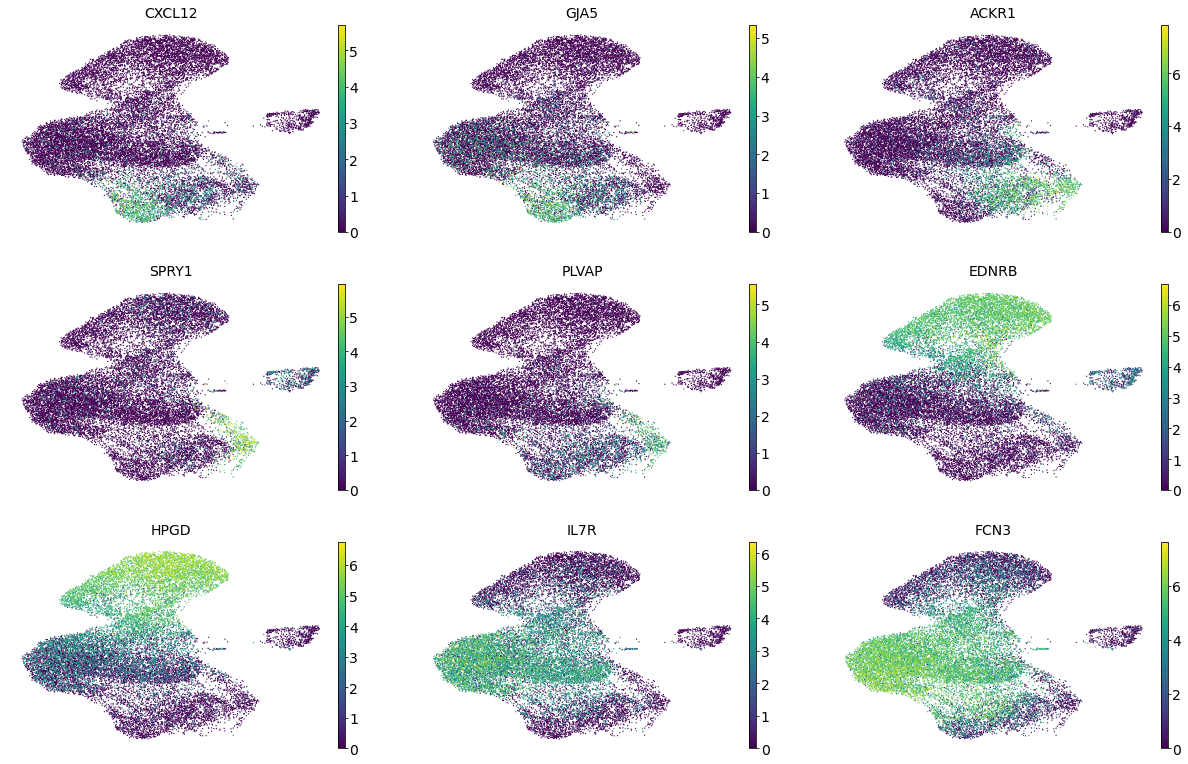

In [182]:
sc.pl.umap(query, color=['CXCL12', 'GJA5', 'ACKR1', 'SPRY1', 'PLVAP', 'EDNRB', 'HPGD', 'IL7R', 'FCN3'], ncols=3, frameon=False, legend_fontsize='small',
           show=True, save='markers_endothelial_reference.pdf')

In [183]:
endothelial_all = adata[np.logical_or(adata.obs['paper_annotation'].isin(endothelial_cells), adata.obs['cell_ontology_class'].isin(endothelial_cells_ts))].copy()
endothelial_all = endothelial_all[
    endothelial_all.obs['popv_prediction'].isin(endothelial_all.obs['popv_prediction'].value_counts().index[endothelial_all.obs['popv_prediction'].value_counts() > 10])
]

/home/cane/miniconda3/lib/python3.8/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


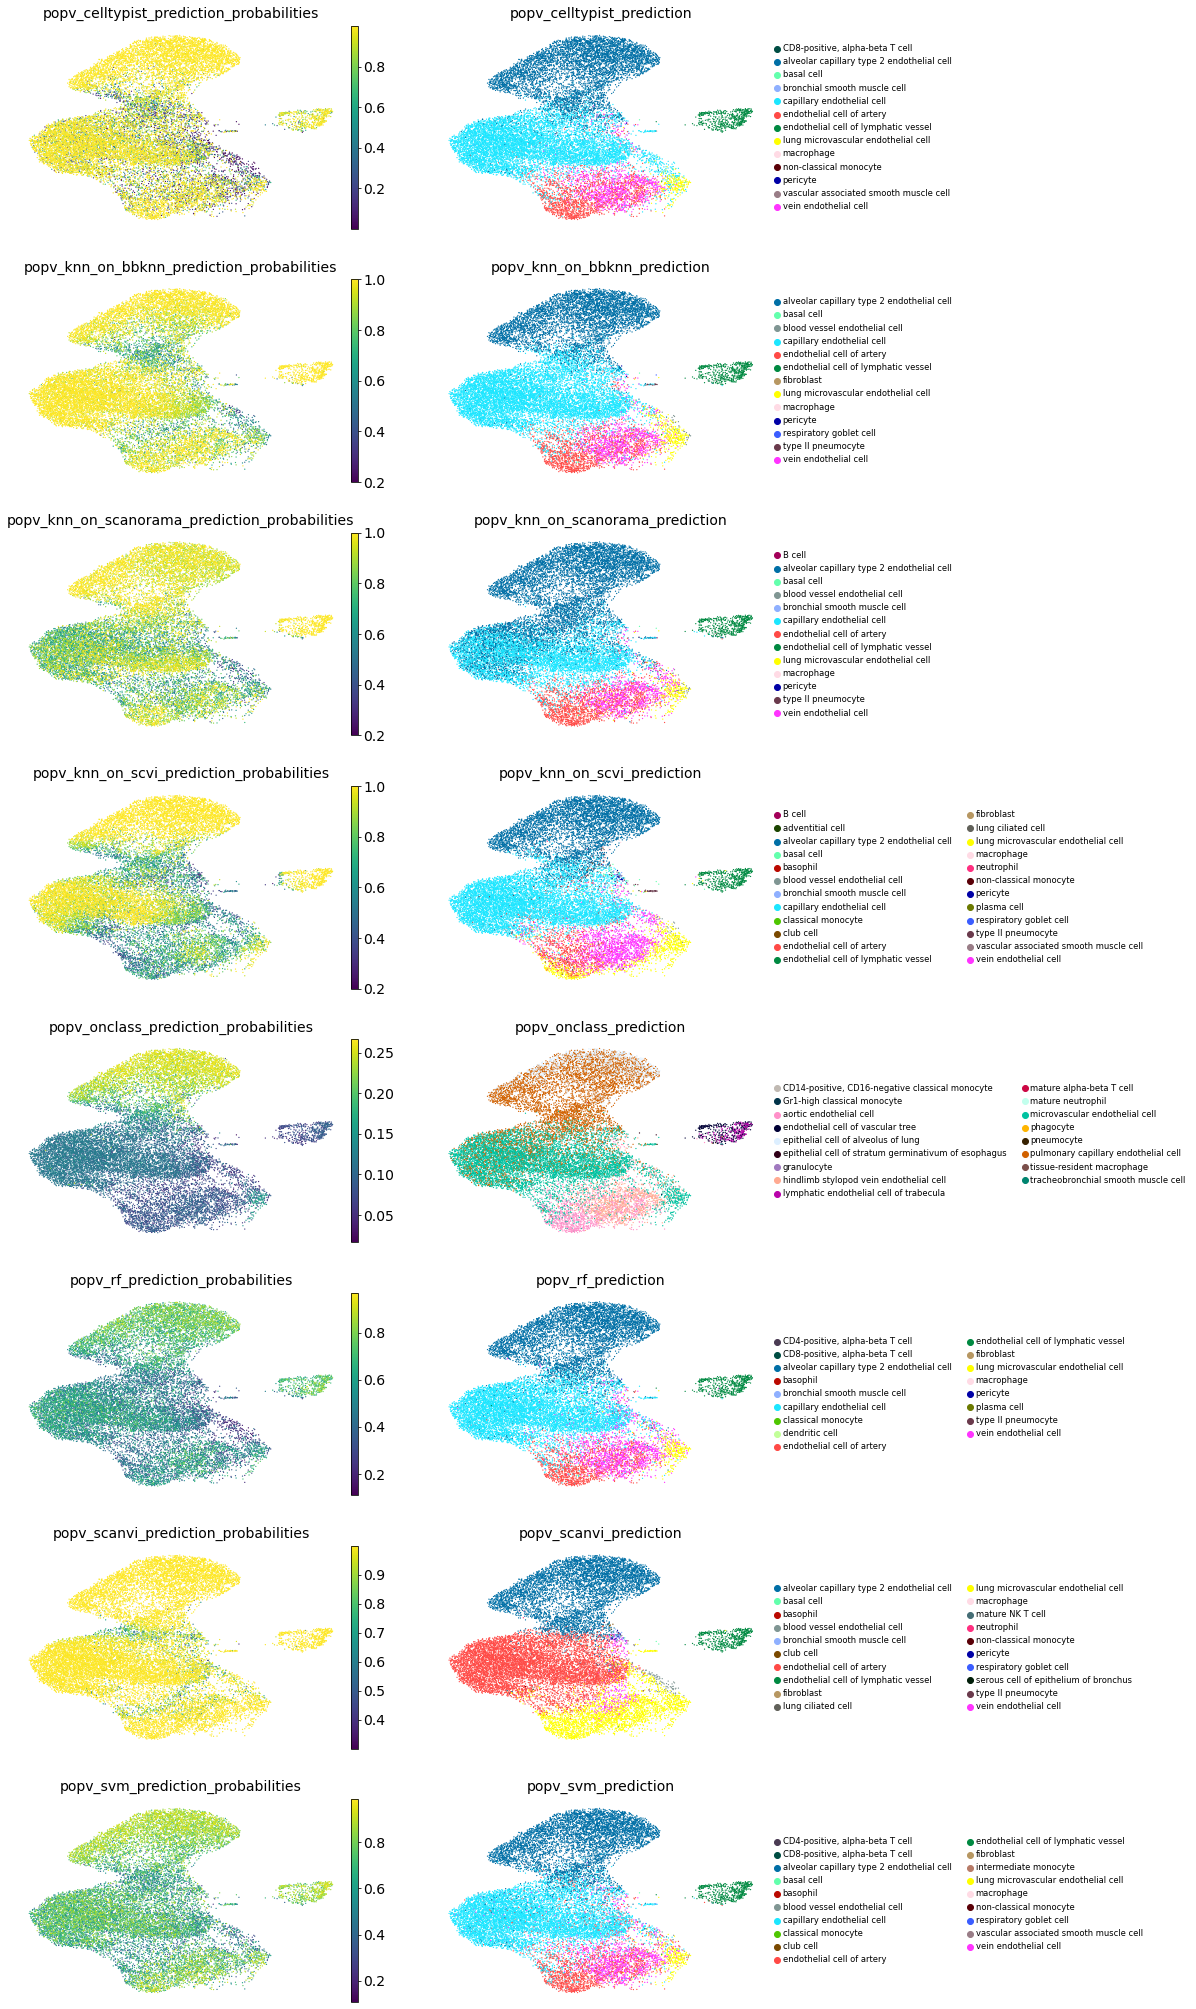

In [185]:
cell_types = pd.unique(endothelial_all.obs[[i for i in endothelial_all.uns['prediction_keys']]].values.ravel('K'))
palette = palettes.default_102
sub_cluster_id_colors = {i: j for i, j in zip(list(cell_types), palette)}
color_keys = [[i+'_probabilities', i] for i in query.uns['prediction_keys']]
color_keys =  sum(color_keys, [])
sc.pl.umap(query, color=color_keys, ncols=2, palette=sub_cluster_id_colors, frameon=False, legend_fontsize='small',
           show=True, save='predictors_endothelial.pdf')


In [135]:
query.obs['popv_onclass_prediction'].value_counts()

microvascular endothelial cell                          7885
pulmonary capillary endothelial cell                    5968
epithelial cell of alveolus of lung                     1534
aortic endothelial cell                                 1389
hindlimb stylopod vein endothelial cell                 1174
endothelial cell of vascular tree                        281
lymphatic endothelial cell of trabecula                  216
tissue-resident macrophage                                 8
pneumocyte                                                 6
tracheobronchial smooth muscle cell                        4
granulocyte                                                2
epithelial cell of stratum germinativum of esophagus       2
mature neutrophil                                          1
mature alpha-beta T cell                                   1
phagocyte                                                  1
Gr1-high classical monocyte                                1
CD14-positive, CD16-nega

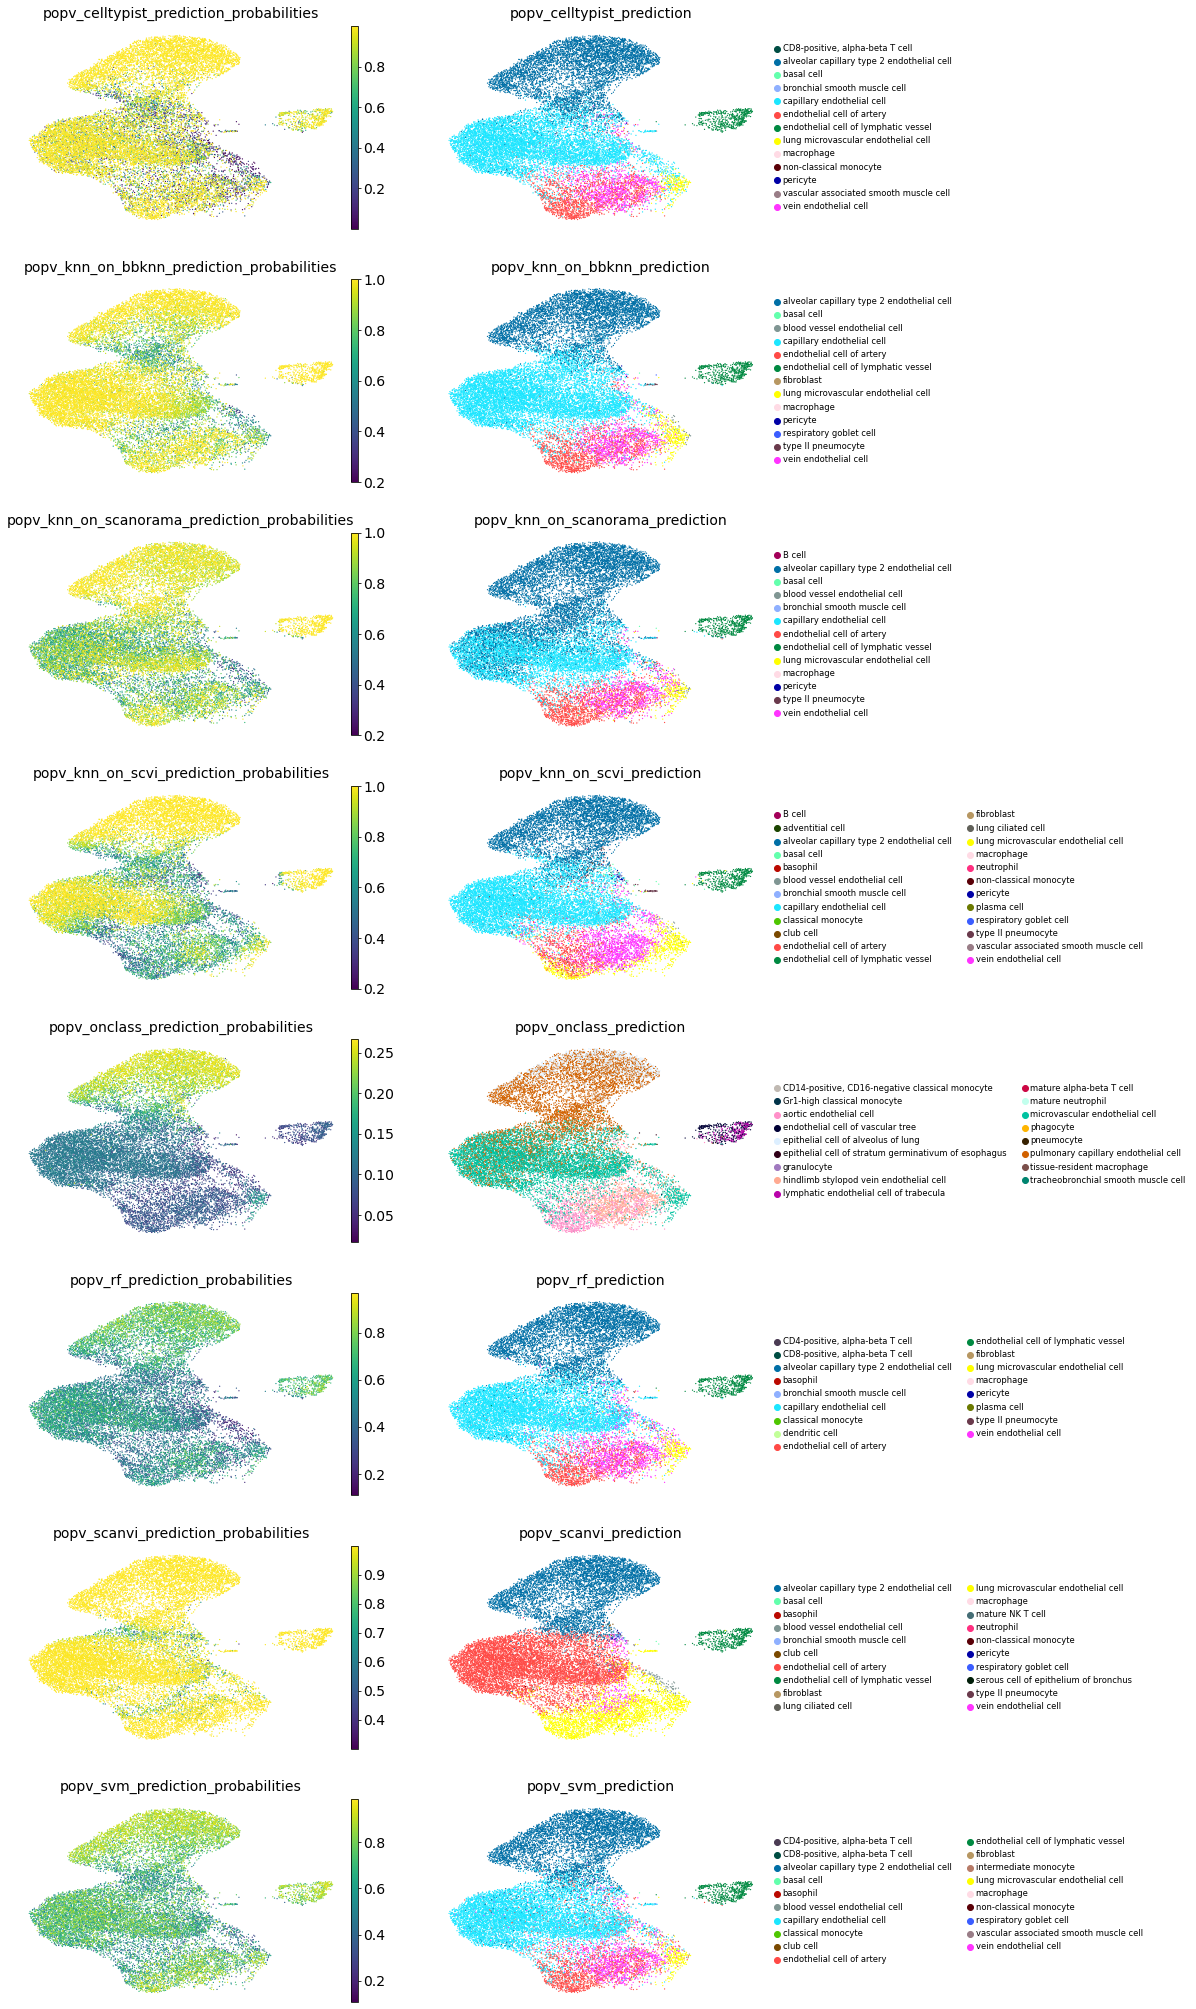

In [134]:
sc.pl.umap(query, color=color_keys, ncols=2, palette=sub_cluster_id_colors, frameon=False, legend_fontsize='small',
           show=True, save='predictors_endothelial.pdf')